In [1]:
import torch.nn as nn
import torch
import numpy as np
from PIL import Image
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm
import sys

import random
import matplotlib.pyplot as plt

## <span style="color:red;">定义模型</span>

In [2]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_layers, out_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Sequential(nn.Linear(a,b,bias=True),nn.ReLU())
              for (a, b) in zip([in_dim] + hidden_layers[:-1], hidden_layers)]
        )
        self.output_layers = nn.Linear(hidden_layers[-1], out_dim, bias=True)
    
    def __make_layers(self):
        pass
    
    def forward(self, x):
        x = self.layers(x)
        x = self.output_layers(x)
        return x

## 基本参数

In [3]:
#----base parameters----------------------------------------
batch_size = 64
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
learing_rate = 1e-4
epochs = 30
to_save = True # whether save model, True -> save, False -> not save
model_name = "mlp"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 加载数据集

In [4]:
data_transform = {
    "train": transforms.Compose([
#         transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(0.1307, 0.3081),
    ]),
    "val": transforms.Compose([
#         transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(0.1307, 0.3081),
    ])}


#----load datasets----------------------------------------
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform = data_transform["train"],
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=nw
)

validate_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    transform = data_transform["val"]
)

val_loader = DataLoader(
    validate_dataset,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=nw
)

## 查看部分数据集

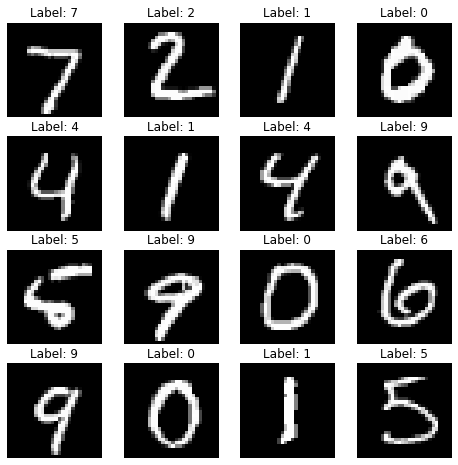

In [5]:
imgs_num = 16
sqrt_imgs_num = int(imgs_num**(1/2))
assert sqrt_imgs_num**2 == imgs_num, f"invalid imgs_num: {imgs_num}"

images_labels = list(validate_dataset)[:imgs_num]

fig, axes = plt.subplots(nrows=sqrt_imgs_num, ncols=sqrt_imgs_num, figsize=(8,8))
for i, (image, label) in enumerate(images_labels):
    ax = axes[i//sqrt_imgs_num, i%sqrt_imgs_num]
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

## 保存训练日志

In [6]:
#----save logs----------------------------------------
log_summary = SummaryWriter(log_dir='/root/tf-logs')

## 模型训练和保存

In [7]:
print(f"using {device} device.")
print(f"Using {nw} dataloader workers every process")
print(f"using {len(train_dataset)} images for training, {len(validate_dataset)} images for validation.")

#----load model---------------------------------------------
net = MLP(in_dim=28*28, hidden_layers=[1024,512,128,64], out_dim=10)
net.to(device)

#----load lose-function and optimizer----------------------------------------
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learing_rate)


best_acc = 0.0

iteration = []
iteration2 = []
train_acc = []
val_acc = []

train_loss = 0 # accumulated loss while training
val_loss = 0.0 # accumulated loss while validating
for epoch in range(epochs):
    # train
    net.train()
    acc = 0
    total = 0
    train_loader = tqdm(train_loader, file=sys.stdout)
    for step, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        total += images.shape[0]
        images = torch.flatten(images,start_dim = 1)
        
        outputs = net(images.to(device))
        predicts = torch.max(outputs, dim=1)[1]
        acc += torch.eq(predicts, labels.to(device)).sum().item()
        
        loss = loss_function(outputs, labels.to(device))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
        loss0 = (train_loss)/(len(iteration)+1)
        iteration.append(loss0)
        train_loader.desc = f"train epoch[{epoch+1}/{epochs}] loss:{loss0:.3f} accuracy:{acc/total:.3f}"
        log_summary.add_scalar('Loss/train',scalar_value=loss0,global_step=len(iteration))
        
    train_acc.append(acc/total)
    log_summary.add_scalar('Accuracy/train',scalar_value=(acc/total),global_step=epoch) 
    # validate
    net.eval()
    acc = 0.0  # accumulated accuracy number each epoch
    total = 0 # accumulated images number each epoch
    with torch.no_grad():
        val_loader = tqdm(val_loader, file=sys.stdout)
        for step, (images, labels) in enumerate(val_loader):
            total += images.shape[0]
            images = torch.flatten(images,start_dim = 1)
            
            outputs = net(images.to(device))
            predicts = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predicts, labels.to(device)).sum().item()
            
            loss = loss_function(outputs, labels.to(device))
            val_loss += loss.item()
            
            loss0 = (val_loss)/(len(iteration2)+1)
            iteration2.append(loss0)
            val_loader.desc = f"valid epoch[{epoch+1}/{epochs}] loss:{loss0:.3f} accuracy:{acc/total:.3f}"
            log_summary.add_scalar('Loss/valid',scalar_value=loss0,global_step=len(iteration2))
#             log_summary.add_scalar('Accuracy/valid',scalar_value=acc/total,global_step=iteration2)
    
    val_acc.append(acc/total)
    log_summary.add_scalar('Accuracy/valid',scalar_value=acc/total,global_step=epoch)
    
    if to_save and (acc/total) > best_acc:
        best_acc = acc/total
        save_path = f'./pth/{model_name}.pth'
        torch.save(net.state_dict(), save_path)

print('Finished Training')

using cuda:0 device.
Using 8 dataloader workers every process
using 60000 images for training, 10000 images for validation.
valid epoch[30/30] loss:0.091 accuracy:0.979: 100%|██████████| 157/157 [00:00<00:00, 163.56it/s]
Finished Training


## 可视化训练数据

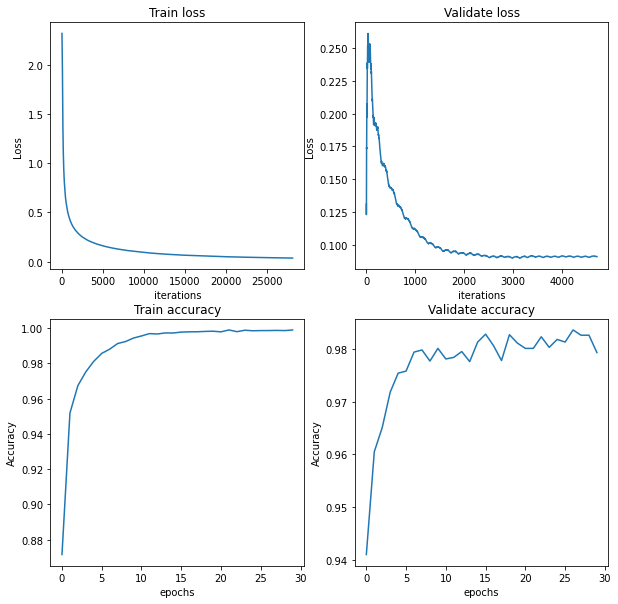

In [8]:
data = [iteration, iteration2, train_acc, val_acc]
titles = ["Train loss", "Validate loss", "Train accuracy", "Validate accuracy"]
xlabels = ["iterations"] * 2 + ["epochs"] * 2
ylabels = ["Loss"] * 2 + ["Accuracy"] * 2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    
    ax.plot(range(len(data[i])), data[i])
    ax.set_title(f"{titles[i]}")
    ax.set_xlabel(f"{xlabels[i]}")
    ax.set_ylabel(f"{ylabels[i]}")

## 查看网络结构

In [9]:
net

MLP(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (output_layers): Linear(in_features=64, out_features=10, bias=True)
)

## 模型评估(从测试集中随机选取9张图片查看模型的预测结果)

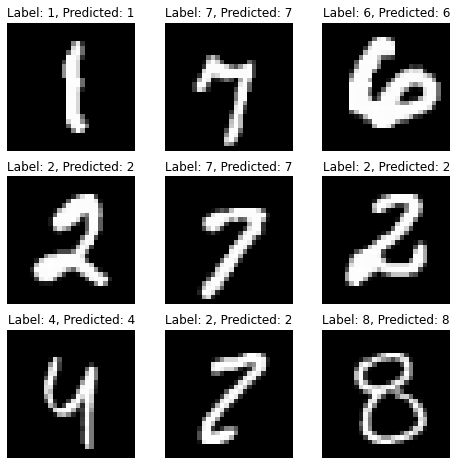

In [10]:
import random
import matplotlib.pyplot as plt
# randomly select 9 images from validate_set
# note that the strcuture of validate_dataset is (image, label), which is Similar to list(tuple)
# image size = [1, 28, 28], image type = <class 'torch.Tensor'>
# label type = <class 'int'>
images_labels = random.sample(list(validate_dataset), 9)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
with torch.no_grad():
    for i, (image, label) in enumerate(images_labels):
        image = (image - 0.1307) / 0.3081
        image = torch.flatten(image,start_dim = 1)
        output = net(image.to(device))
        predict = torch.max(output, dim=1)[1]
        
        ax = axes[i//3, i%3]
        ax.imshow(image.reshape(28,28).numpy().squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}, Predicted: {predict.item()}")
        ax.axis('off')